<a href="https://colab.research.google.com/github/ThourayaBchir/Chatbot_with_LSTM_and_attention/blob/master/trnasformers_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torch datasets tokenizers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

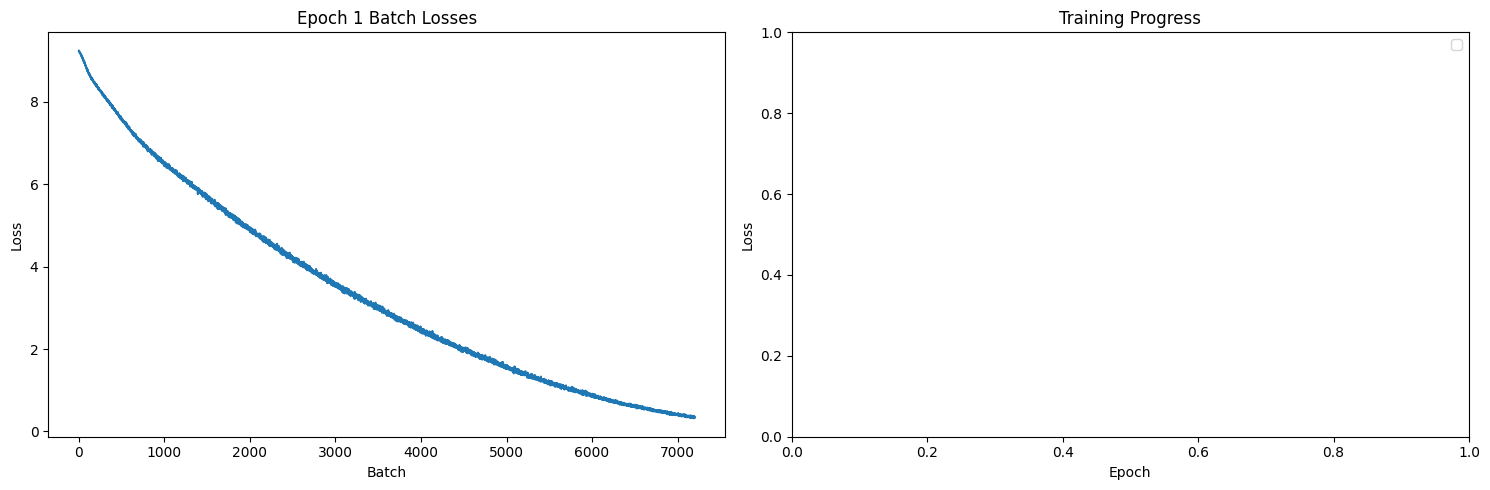

Epoch 1/10 | Batch 7200/82112 | Loss 0.3365


KeyboardInterrupt: 

In [ ]:


import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from datasets import load_dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from datasets import load_dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR


# ──────────────────────────────────────────────────────────────────────────────
# 1) Fast Tridiagonal Solver (Thomas algorithm, O(n))
# ──────────────────────────────────────────────────────────────────────────────

def tridiag_solve_thomas(
    kappa: torch.Tensor,
    alpha: float,
    B: torch.Tensor,
) -> torch.Tensor:
    """
    Solve (αI + L_κ) X = B along dim=1 exactly in O(n) time and O(n) extra memory,
    using the Thomas (tridiagonal) algorithm.
    kappa: [B, n, C], B: [B, n, C] -> X: [B, n, C]
    """
    Bsz, n, C = B.shape
    # build diagonals
    k_mid = 0.5 * (kappa[:, :-1] + kappa[:, 1:])   # [B, n-1, C]
    a = (alpha
         + F.pad(k_mid, (0,0,1,0))
         + F.pad(k_mid, (0,0,0,1)))                # main diag: [B, n, C]
    b = -k_mid                                      # upper diag: [B, n-1, C]
    c = -k_mid                                      # lower diag: [B, n-1, C]

    # flatten batch+channels
    M = Bsz * C
    a = a.permute(0,2,1).reshape(M, n)              # [M, n]
    b = b.permute(0,2,1).reshape(M, n-1)            # [M, n-1]
    c = c.permute(0,2,1).reshape(M, n-1)            # [M, n-1]
    d = B.permute(0,2,1).reshape(M, n)              # [M, n]

    # allocate space for the modified coefficients
    # we'll overwrite b in-place to store the "c'" (upper-modified),
    # and overwrite d to store the "d'"
    c_prime = b.clone()
    d_prime = d.clone()

    # forward sweep
    # first row
    d_prime[:, 0] = d[:, 0] / a[:, 0]
    c_prime[:, 0] = b[:, 0] / a[:, 0]
    for i in range(1, n-1):
        denom = a[:, i] - c[i-1] * c_prime[:, i-1]
        d_prime[:, i] = (d[:, i] - c[:, i-1] * d_prime[:, i-1]) / denom
        c_prime[:, i] = b[:, i] / denom
    # last element of d′
    denom = a[:, n-1] - c[:, n-2] * c_prime[:, n-2]
    d_prime[:, n-1] = (d[:, n-1] - c[:, n-2] * d_prime[:, n-2]) / denom

    # back substitution
    x = torch.empty_like(d_prime)
    x[:, -1] = d_prime[:, -1]
    for i in range(n-2, -1, -1):
        x[:, i] = d_prime[:, i] - c_prime[:, i] * x[:, i+1]

    # reshape back to [B, n, C]
    return x.view(Bsz, C, n).permute(0,2,1)



# ──────────────────────────────────────────────────────────────────────────────
# 2) Reaction–Diffusion Components
# ──────────────────────────────────────────────────────────────────────────────

class DiffusivityNet(nn.Module):
    def __init__(self, d_s, hidden_dim=128, eps=1e-3):
        super().__init__()
        self.eps = eps
        self.net = nn.Sequential(
            nn.Linear(6*d_s, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, 2*d_s)
        )
    def forward(self, U, V):
        # U, V: [B, n, d_s]
        Up = F.pad(U.transpose(1,2),(1,1),mode="replicate").transpose(1,2)
        Vp = F.pad(V.transpose(1,2),(1,1),mode="replicate").transpose(1,2)
        feats = torch.cat([Up[:,:-2], Up[:,1:-1], Up[:,2:],
                           Vp[:,:-2], Vp[:,1:-1], Vp[:,2:]], dim=-1)
        kU, kV = self.net(feats).chunk(2, dim=-1)
        return F.softplus(kU) + self.eps, F.softplus(kV) + self.eps


class ReactionNet(nn.Module):
    def __init__(self, d_s, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2*d_s, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, 2*d_s)
        )
    def forward(self, U, V):
        a, b = self.net(torch.cat([U, V], dim=-1)).chunk(2, dim=-1)
        return a, b


# ──────────────────────────────────────────────────────────────────────────────
# 3) Multigrid Reaction–Diffusion Attention Block
# ──────────────────────────────────────────────────────────────────────────────

class MultiGridTRDRBlock(nn.Module):
    def __init__(self, d_model, d_s=None, alpha=1e-2, grid_factor=4):
        super().__init__()
        d_s = d_s or d_model // 2
        self.alpha = alpha
        self.s = grid_factor
        # projections
        self.Wu_f = nn.Parameter(torch.randn(d_model, d_s)*0.02)
        self.Wv_f = nn.Parameter(torch.randn(d_model, d_s)*0.02)
        self.Wu_c = nn.Parameter(torch.randn(d_model, d_s)*0.02)
        self.Wv_c = nn.Parameter(torch.randn(d_model, d_s)*0.02)
        self.Wm   = nn.Parameter(torch.randn(2*d_s, d_model)*0.02)
        # learned RD nets
        self.diff_net  = DiffusivityNet(d_s)
        self.react_net = ReactionNet(d_s)
        self.mlp       = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, d_model))

    def forward(self, H):
        B, n, _ = H.shape
        # Fine scale
        U = H @ self.Wu_f; V = H @ self.Wv_f
        kU, kV = self.diff_net(U, V)
        a, b   = self.react_net(U, V)
        FU = a - (b+1)*U + U*U*V
        FV = b*U       - U*U*V
        U_f = tridiag_solve(kU, self.alpha, U + FU)
        V_f = tridiag_solve(kV, self.alpha, V + FV)

        # Coarse scale
        # downsample every s-th token
        Hc     = H[:, ::self.s, :]
        Uc = Hc @ self.Wu_c; Vc = Hc @ self.Wv_c
        kcU, kcV = self.diff_net(Uc, Vc)
        ac, bc   = self.react_net(Uc, Vc)
        FUc = ac - (bc+1)*Uc + Uc*Uc*Vc
        FVc = bc*Uc       - Uc*Uc*Vc
        Uc_star = tridiag_solve(kcU, self.alpha, Uc + FUc)
        Vc_star = tridiag_solve(kcV, self.alpha, Vc + FVc)
        # upsample back to length n
        U_c_up = F.interpolate(Uc_star.transpose(1,2), size=n, mode='linear', align_corners=False).transpose(1,2)
        V_c_up = F.interpolate(Vc_star.transpose(1,2), size=n, mode='linear', align_corners=False).transpose(1,2)

        # Fuse
        delta = torch.cat([U_f + U_c_up, V_f + V_c_up], dim=-1) @ self.Wm
        Hs = H + delta + self.mlp(delta)
        return Hs

# ──────────────────────────────────────────────────────────────────────────────
# Rotary Positional Embeddings (RoPE) utilities
# ──────────────────────────────────────────────────────────────────────────────

def rotary_embedding(dim, seq_len, device):
    # dim = hidden dimension per head
    inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2, device=device).float() / dim))
    t = torch.arange(seq_len, device=device).float()
    freqs = torch.einsum('i,j->ij', t, inv_freq)  # (seq_len, dim/2)
    # interleave to (seq_len, dim): [f0, f0, f1, f1, ...]
    freqs = torch.stack((freqs, freqs), dim=-1).view(seq_len, dim)
    sin = freqs.sin().unsqueeze(0).unsqueeze(1)  # (1,1,seq_len,dim)
    cos = freqs.cos().unsqueeze(0).unsqueeze(1)
    return sin, cos


def rotate_half(x):
    # rotate pairs: [..., x0, x1, x2, x3, ...] -> [..., -x1, x0, -x3, x2, ...]
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary(q, k, sin, cos):
    # q, k: (B, heads, T, dim)
    # sin, cos: (1,1,seq_len, dim)
    q_rot = (q * cos) + (rotate_half(q) * sin)
    k_rot = (k * cos) + (rotate_half(k) * sin)
    return q_rot, k_rot

# ──────────────────────────────────────────────────────────────────────────────
# 1) Configuration and Model Definition
# ──────────────────────────────────────────────────────────────────────────────
class GPTConfig:
    def __init__(self,
                 vocab_size,
                 seq_len,
                 d_model=256,
                 heads=4,
                 num_layers=4,
                 d_ff=1024,
                 dropout=0.1,
                 layernorm_eps=1e-5):
        self.vocab_size    = vocab_size
        self.seq_len       = seq_len
        self.d_model       = d_model
        self.heads         = heads
        self.num_layers    = num_layers
        self.d_k           = d_model // heads
        self.d_ff          = d_ff
        self.dropout       = dropout
        self.layernorm_eps = layernorm_eps

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_heads = config.heads
        self.d_k       = config.d_k
        self.scale     = self.d_k ** -0.5
        self.qkv_proj  = nn.Linear(config.d_model, 3 * config.d_model)
        self.out_proj  = nn.Linear(config.d_model, config.d_model)
        self.dropout   = nn.Dropout(config.dropout)
        self.register_buffer(
            'mask',
            torch.tril(torch.ones(config.seq_len, config.seq_len)).view(1,1,config.seq_len,config.seq_len)
        )

    def forward(self, x, attention_mask=None, past_kv=None, sincos=None):
        B, T, C = x.size()
        qkv = self.qkv_proj(x).view(B, T, 3, self.num_heads, self.d_k).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # apply rotary
        if sincos is not None:
            sin, cos = sincos
            sin, cos = sin[:,:,:T,:], cos[:,:,:T,:]
            q, k = apply_rotary(q, k, sin, cos)

        if past_kv is not None:
            pk, pv = past_kv
            k = torch.cat([pk, k], dim=2)
            v = torch.cat([pv, v], dim=2)

        scores = (q @ k.transpose(-2, -1)) * self.scale
        scores = scores.masked_fill(self.mask[:,:,:T,:T] == 0, -float('inf'))
        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask == 0, -float('inf'))
        probs = F.softmax(scores, dim=-1)
        probs = self.dropout(probs)
        out = probs @ v
        out = out.transpose(1,2).reshape(B, T, C)
        return self.out_proj(out), (k, v)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1     = nn.Linear(config.d_model, config.d_ff)
        self.fc2     = nn.Linear(config.d_ff,  config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.gelu(self.fc1(x))))

class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1  = nn.LayerNorm(config.d_model, eps=config.layernorm_eps)
        self.attn = MultiGridTRDRBlock(config.d_model, d_s=config.d_model//2, grid_factor=4)
        self.ln2  = nn.LayerNorm(config.d_model, eps=config.layernorm_eps)
        self.ff   = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff), nn.GELU(), nn.Linear(config.d_ff, config.d_model)
        )
        self.drop = nn.Dropout(config.dropout)

    def forward(self, x, *args, **kwargs):
        # drop past_kv, attention_mask, rotary
        x = x + self.drop(self.attn(self.ln1(x)))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x, None

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        sin, cos = rotary_embedding(config.d_k, config.seq_len, device='cpu')
        self.register_buffer('sin_emb', sin)
        self.register_buffer('cos_emb', cos)
        self.drop    = nn.Dropout(config.dropout)
        self.layers  = nn.ModuleList([DecoderLayer(config) for _ in range(config.num_layers)])
        self.ln_f    = nn.LayerNorm(config.d_model, eps=config.layernorm_eps)
        self.head    = nn.Linear(config.d_model, config.vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight

    def forward(self, x, attention_mask=None, past_kvs=None):
        B, T = x.size()
        device = x.device
        x = self.tok_emb(x)
        x = self.drop(x)

        new_pasts = []
        sincos = (self.sin_emb.to(device), self.cos_emb.to(device))
        for i, layer in enumerate(self.layers):
            past = past_kvs[i] if past_kvs is not None else None
            x, new_kv = layer(x, attn_mask=attention_mask, past_kv=past, sincos=sincos)
            new_pasts.append(new_kv)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, new_pasts

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=None):
        self.eval()
        past_kvs = [None] * len(self.layers)
        for _ in range(max_new_tokens):
            attention_mask = (idx != 0).unsqueeze(1).unsqueeze(2)
            logits, past_kvs = self(idx, attention_mask=attention_mask, past_kvs=past_kvs)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                vals, _ = torch.topk(logits, top_k)
                min_val = vals[:, -1].unsqueeze(-1)
                logits = torch.where(logits < min_val, -float('inf'), logits)
            if top_p is not None:
                sorted_logits, sorted_idx = torch.sort(logits, descending=True)
                probs = F.softmax(sorted_logits, dim=-1)
                cum_probs = torch.cumsum(probs, dim=-1)
                sorted_logits[cum_probs > top_p] = -float('inf')
                logits = torch.zeros_like(logits).scatter(-1, sorted_idx, sorted_logits)

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

# ──────────────────────────────────────────────────────────────────────────────
# Training loop: unpack logits
# ──────────────────────────────────────────────────────────────────────────────
# In your training loop use:
# logits, _ = model(x, attention_mask)
# loss = F.cross_entropy(logits.view(-1, config.vocab_size), y.view(-1))

# Initialize weights

def init_weights(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
    if isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.bias, 0)
        nn.init.constant_(module.weight, 1.0)


# ──────────────────────────────────────────────────────────────────────────────
# 4) Tokenize WikiText-2 with train/val split
# ──────────────────────────────────────────────────────────────────────────────
def prepare_datasets():
    # Load and split raw data
    raw = load_dataset("wikitext", "wikitext-2-raw-v1")
    train_text = "\n".join([t for t in raw["train"]["text"] if t.strip()])
    val_text = "\n".join([t for t in raw["validation"]["text"] if t.strip()])

    # Train tokenizer on training data only
    tokenizer = ByteLevelBPETokenizer()
    with open("train_temp.txt", "w") as f:
        f.write(train_text)
    tokenizer.train(["train_temp.txt"], vocab_size=10000, min_frequency=2,
                   special_tokens=["<s>", "<pad>", "</s>", "<unk>", "<mask>"])
    os.makedirs("tokenizer", exist_ok=True)
    tokenizer.save_model("tokenizer")
    os.remove("train_temp.txt")

    # Encode both splits
    train_ids = tokenizer.encode(train_text).ids
    val_ids = tokenizer.encode(val_text).ids

    return tokenizer, torch.tensor(train_ids, dtype=torch.long), torch.tensor(val_ids, dtype=torch.long)

tokenizer, train_data, val_data = prepare_datasets()
vocab_size = tokenizer.get_vocab_size()

# ──────────────────────────────────────────────────────────────────────────────
# 5) Dataset & DataLoaders
# ──────────────────────────────────────────────────────────────────────────────
seq_len = 512
batch_size = 32

class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+1+self.seq_len]
        return x, y

train_dataset = TextDataset(train_data, seq_len)
val_dataset = TextDataset(val_data, seq_len)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)


# ──────────────────────────────────────────────────────────────────────────────
# Checkpoint Utilities
# ──────────────────────────────────────────────────────────────────────────────
def save_checkpoint(model, optimizer, scheduler, scaler, epoch, loss, path="checkpoints"):
    os.makedirs(path, exist_ok=True)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'epoch': epoch,
        'loss': loss,
        'config': config.__dict__,
    }
    torch.save(checkpoint, f"{path}/checkpoint_epoch_{epoch}.pt")
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(path, model, optimizer=None, scheduler=None, scaler=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from epoch {epoch} with loss {loss:.4f}")
    return epoch




import time
import matplotlib.pyplot as plt

# Add these at the beginning of your training section
train_losses = []
batch_times = []
epoch_times = []
start_time = time.time()
#
# ──────────────────────────────────────────────────────────────────────────────
# 6) Training Loop with Validation & Checkpointing
# ──────────────────────────────────────────────────────────────────────────────
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    model.train()
    return avg_loss
# ──────────────────────────────────────────────────────────────────────────────
# 6) Training Loop with Live Plotting
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.ion()  # Enable interactive mode

def train(model, train_loader, val_loader, optimizer, scaler, scheduler, epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        epoch_losses = []

        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            optimizer.zero_grad()
            with autocast():
                logits, _ = model(x)
                loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            epoch_losses.append(loss.item())

            # Live plotting every N batches
            if batch_idx % 200 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(15, 5))

                # Current epoch batch losses
                plt.subplot(1, 2, 1)
                plt.plot(epoch_losses)
                plt.title(f'Epoch {epoch+1} Batch Losses')
                plt.xlabel('Batch')
                plt.ylabel('Loss')

                # Overall training progress
                plt.subplot(1, 2, 2)
                if len(train_losses) > 0:
                    plt.plot(train_losses, 'b-', label='Train')
                if len(val_losses) > 0:
                    plt.plot(val_losses, 'r-', label='Validation')
                plt.title('Training Progress')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()

                plt.tight_layout()
                plt.show()

                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | Loss {loss.item():.4f}")

        # Calculate epoch metrics
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits, _ = model(x)
                val_loss += F.cross_entropy(logits.view(-1, vocab_size), y.view(-1)).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Save checkpoint if improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pt")
            save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_val_loss)
            print(f"New best model saved with val loss {best_val_loss:.4f}")

        # Final epoch update
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epoch_losses)
        plt.title(f'Epoch {epoch+1} Final Batch Losses')
        plt.xlabel('Batch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, 'b-', label='Train')
        plt.plot(val_losses, 'r-', label='Validation')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.1f}s")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Best Val: {best_val_loss:.4f}")

    plt.ioff()  # Turn off interactive mode when done
    return train_losses, val_losses

# Initialize and train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = GPTConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    d_model=256, heads=4, num_layers=4, d_ff=1024, dropout=0.1
)
model = GPT(config).to(device)
model.apply(init_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scaler = GradScaler()
scheduler = OneCycleLR(optimizer, max_lr=3e-4,
                      total_steps=3*len(train_loader), pct_start=0.1,
                      anneal_strategy="cos")

# Start training
train_losses, val_losses = train(
    model, train_loader, val_loader,
    optimizer, scaler, scheduler,
    epochs=10, device=device
)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1


In [ ]:
# Check model device
print(next(model.parameters()).device)

# Check tensor device


cuda:0


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# 1) Make sure CUDA is visible
assert torch.cuda.is_available(), "CUDA not detected!"

# 2) Load model straight onto GPU
model_name = "gpt2"  # or your checkpoint
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForCausalLM.from_pretrained(model_name).cuda()
model.eval()

# 3) Tokenize and move inputs to GPU
prompt = "The meaning of life is"
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.cuda() for k, v in inputs.items()}

# 4) Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits  = outputs.logits
    # …and so on


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
